# Define Dependencies

In [1]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import scipy as sp
from scipy import fftpack

Using TensorFlow backend.


In [2]:
# Global Variables
windowSize = 7
numPCAcomponents = 64
testRatio = 0.95

# Define the neccesary functions for later use

In [5]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'data')
    data = sio.loadmat("../../Datasets/Indian pines/Indian_pines_corrected.mat")['indian_pines_corrected']
    labels = sio.loadmat("../../Datasets/Indian pines/Indian_pines_gt.mat")['indian_pines_gt']
    
    return data, labels

def reports (X_test,y_test,model):
    Y_pred = model.predict(X_test,batch_size=8)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=8)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [4]:
X_test = np.load("../../data/XtestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("../../data/ytestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [5]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [6]:
# load the model architecture and weights
model = load_model('my_model_pca_'+str(testRatio)+str(numPCAcomponents)+str(windowSize)+'h5')

In [7]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test,model)
classification = str(classification)
confusion = str(confusion)
numComponents = 64
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numComponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w+') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

 176/9737 [..............................] - ETA: 8s 

/home/dkoder/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


9737/9737 [==============================] - 6s 627us/step


In [8]:
# load the original image
X, y = loadIndianPinesData()

In [9]:

def dost_bw(l):
    out = np.zeros(int(2*np.log2(l)))
    l1 = np.arange(np.log2(l)-2,-1,-1)
    l2 = np.arange(0,np.log2(l)-1)
    out[1:int(1+np.log2(l)-1)]=l1
    out[-int(np.log2(l)-1):]=l2
    
    out = np.exp2(out).astype(np.int16)
    return out

def dost(inp):
    l = inp.shape[0]
    fft_inp = fftpack.fftshift(fftpack.fft(fftpack.ifftshift(inp,axes=0),axis=0),axes=0)
    #plt.figure(figsize = (30,5))
    #ax = np.linspace(-512,511,2**10)
    #plt.plot(ax,fft_inp[0,:])
    bw_inp = dost_bw(l)
#     print(bw_inp)
    k = 0
    dost_inp = np.zeros_like(fft_inp)

    for r in bw_inp:
        if(r==1):
            dost_inp[k,:] = fft_inp[k,:]
            k = k+r
        else:
            dost_inp[k:r+k,:] = fftpack.fftshift(fftpack.ifft(fftpack.ifftshift(fft_inp[k:r+k,:],axes=0),axis=0),axes=0)
            k = k+r

#     plt.plot(fft_inp)
    #plt.figure(figsize = (20,5))
    #plt.plot(np.abs(dost_inp[0,:]))
    
    
    return dost_inp
    

In [11]:
Xn = np.zeros([X.shape[0],X.shape[1],256])
Xn[:,:,:200] = X

In [12]:
Xn = dost(Xn.reshape([-1,Xn.shape[2]],order='F').T).T.reshape(Xn.shape,order='F')

In [10]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 7
numComponents = 64

In [11]:
X,pca = applyPCA(X,numComponents=numComponents)

In [12]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = int(y[i+PATCH_SIZE//2, j+PATCH_SIZE//2])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image,batch_size = 8))                         
            outputs[i+PATCH_SIZE//2][j+PATCH_SIZE//2] = prediction+1

ImageView object:
  Interpolation       :  <default>

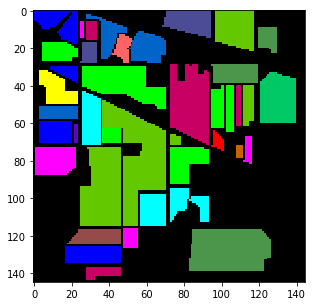

In [11]:
spectral.imshow(classes = y,figsize =(5,5))

In [10]:
y.dtype

dtype('uint8')

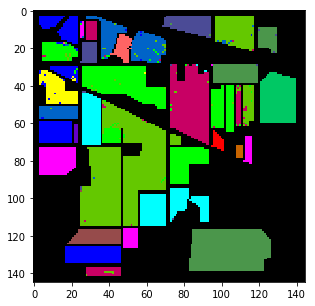

In [29]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

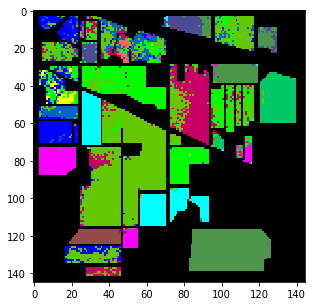

In [17]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

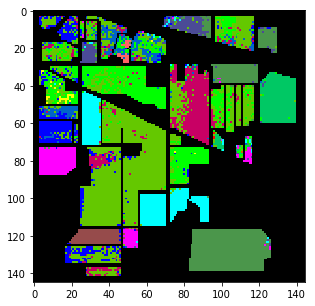

In [14]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))